## Deep Backwards Stochastic Differential Equation

In [65]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

### Implementing the Neural Network for $Z_\theta$ and $q_\theta$

We aim to solve the following stochastic optimal control problem using the **deep BSDE approach**.

---

#### Market Dynamics

- The mid-price evolves as:

$$
dP(t) = \left[ \mu^P + \psi(q(t)) \right] dt + \sigma^P\, dW^P(t)
$$

where $\psi(q) = \gamma q$ is the **permanent impact**.

- The residual demand evolves as:

$$
dD(t) = \rho\,\sigma^D\,dW^P(t) + \sqrt{1 - \rho^2}\,\sigma^D\,dW^D(t)
$$

- The imbalance price evolves as:

$$
dB(t) = \sigma^B\,dW^B(t)
$$

---

#### Execution Price and Running Cost

The execution price includes:
- Mid-price: $P(t)$
- Half-spread: $\operatorname{sign}(q(t)) \cdot \psi(q(t))$
- Temporary impact: $\phi(q(t)) = \eta q(t)$

The **execution price** is:

$$
\tilde{P}(t, q(t)) = P(t) + \operatorname{sign}(q(t)) \psi(q(t)) + \phi(q(t))
$$

The **running cost** is the negative of trading revenue:

$$
f(t, y, q) = -q(t)\cdot\tilde{P}(t, q(t))
$$

---

#### Terminal Cost

Let the imbalance be:

$$
I(T) = X(T) - D(T) + \xi
$$

The terminal cost is:

$$
h(y(T)) = -c_{\text{prod}} \cdot \xi + I(T)^+ \cdot B(T) - I(T)^- \cdot B(T)
$$

where $I^+ = \max(I, 0)$ and $I^- = \max(-I, 0)$.

In our implementation, we set $\xi = 0$ (no conventional production for now).

---

#### Deep BSDE Formulation

We solve the value function backward using:
- State dynamics: $d\boldsymbol{y}(t) = b(t) dt + \Sigma(t)\, dW(t)$
- Value function: $Y(t) = V(t, y(t))$
- Gradient process: $Z(t) = \Sigma(t)^\top \nabla_y V(t, y(t))$

The backward dynamics are:

$$
dY(t) = -f(t, y(t), q(t)) dt + Z(t)^\top dW(t)
$$

with terminal condition:

$$
Y(T) = h(y(T))
$$

We approximate:
- $Y(0)$ as a trainable parameter,
- $Z(t) \approx Z_\theta(t, y(t))$,
- $q(t) \approx q_\theta(t, y(t))$

and minimize the terminal mismatch:

$$
\mathbb{E} \left[ \left( Y(T) - h(y(T)) \right)^2 \right]
$$

This gives a trainable loss for the neural networks representing the value function and control.


In [64]:
# ========== Hyperparameters ==========
T = 1.0
N = 40
dt = T / N
batch_size = 256
dim = 4  # state = (X, P, D, B)

# ========== Model Parameters ==========
mu_P = 0.0
sigma_P = 0.2
sigma_D = 0.15
sigma_B = 0.3
rho = 0.3
gamma = 0.05  # permanent impact
eta = 0.1     # temporary impact
c_prod = 45.0  # production cost
xi = 0.0      # initial inventory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Neural Networks ==========
class ZNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # output shape matches dW dim
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


class QNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


# ========== Impact Functions ==========
def psi(q): return gamma * q
def phi(q): return eta * q

# ========== Generator ==========
def generator(y, q):
    P = y[:, 1:2]  # mid-price
    sign_q = torch.sign(q)
    P_exec = P + sign_q * psi(q) + phi(q)
    return -q * P_exec  # shape: (batch, 1)

# ========== Terminal Cost ==========
def terminal_cost(y, X, D):
    B = y[:, 3:4]
    I = X - D + xi
    I_plus = torch.clamp(I, min=0.0)
    I_minus = torch.clamp(-I, min=0.0)
    return -c_prod * xi + I_plus * B - I_minus * B  # zero production for now

# ========== BSDE Solver ==========
class DeepBSDE(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[0.0]], device=device))
        self.z_net = ZNetwork(state_dim).to(device)
        self.q_net = QNetwork(state_dim).to(device)

    def forward(self):
        # Initial state (X, P, D, B)
        y = torch.zeros(batch_size, dim, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        X, P, D, B = [torch.zeros(batch_size, 1, device=device) for _ in range(4)]

        Y = self.Y0.repeat(batch_size, 1)
        losses = []

        for i in range(N):
            t_input = t.clone()
            z = self.z_net(t_input, y)
            q = self.q_net(t_input, y)
            f = generator(y, q)

            dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
            dWP = dW[:, 0:1]
            dWD = dW[:, 1:2]
            dWB = dW[:, 2:3]

            # Forward SDE updates
            dX = q * dt
            dP = (mu_P + gamma * q) * dt + sigma_P * dWP
            dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
            dB = sigma_B * dWB

            X = X + dX
            P = P + dP
            D = D + dD
            B = B + dB
            y = torch.cat([X, P, D, B], dim=1)

            Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)
            t += dt

        terminal = terminal_cost(y, X, D)
        loss = torch.mean((Y - terminal)**2)
        return loss


# ========== Training ==========
model = DeepBSDE(state_dim=dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.10f}")


Epoch 0: Loss = 0.0184397195
Epoch 50: Loss = 0.0002863439
Epoch 100: Loss = 0.0000855496
Epoch 150: Loss = 0.0000773146
Epoch 200: Loss = 0.0000482227
Epoch 250: Loss = 0.0000551215
Epoch 300: Loss = 0.0000432909
Epoch 350: Loss = 0.0000523233
Epoch 400: Loss = 0.0000464041
Epoch 450: Loss = 0.0000467018
Epoch 500: Loss = 0.0000390804
Epoch 550: Loss = 0.0000385911
Epoch 600: Loss = 0.0000497515
Epoch 650: Loss = 0.0000413125
Epoch 700: Loss = 0.0000363756
Epoch 750: Loss = 0.0000386858
Epoch 800: Loss = 0.0000338900
Epoch 850: Loss = 0.0000385538
Epoch 900: Loss = 0.0000384864
Epoch 950: Loss = 0.0000343260


### Training Loss

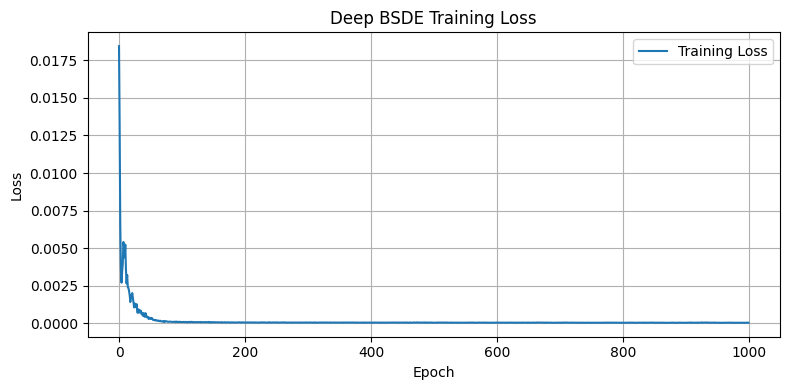

In [67]:
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Deep BSDE Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Analysis of Results

In this section, we analyze the behavior of the learned policy and value function by comparing simulation outcomes with theoretical and economic intuition derived from the structure of the control problem.

---

#### 1. Monotonicity of the Value Function $Y(t)$

- **Theory**: The value function $Y(t)$ represents the expected remaining cost from time $t$ onward.
- **Expected Behavior**: As time progresses and the agent incurs more cost, $Y(t)$ should **decrease in expectation**.
- **Check**: Plot $\mathbb{E}[Y(t)]$ over time across many trajectories. Confirm it is a non-increasing curve.

---

#### 2. Correlation Between Position $X(T)$ and Demand $D(T)$

- **Goal**: Minimize terminal imbalance $I(T) = X(T) + \xi - D(T)$ to avoid costly settlement.
- **Expected Behavior**: Strong **positive correlation** between $X(T)$ and $D(T)$, ideally close to 1.
- **Check**: Simulate many trajectories and compute $\text{Corr}(X(T), D(T))$.

---

#### 3. Sensitivity to Imbalance Prices $B(T)$

- **Economic Intuition**: If terminal imbalance prices are high (large $B(T)$), the agent should reduce imbalance more aggressively.
- **Expected Behavior**:
  - When $B(T)$ is large, the absolute imbalance $|I(T)|$ should be small.
- **Check**:
  - Plot $|I(T)|$ vs. $B(T)$. Look for a **negative trend**.
  - Group samples by bins of $B(T)$, and compute average imbalance per bin.

---

#### 4. Behavior of Optimal Control $q(t)$

- **Smoothness**: With linear impact functions and no strict terminal constraints, optimal control should vary **smoothly** over time.
- **Variability**: More aggressive control in earlier steps if:
  - Imbalance risk is high (e.g. large $\sigma^B$),
  - Demand is volatile (large $\sigma^D$),
  - Price impact is low (small $\eta$, $\gamma$).

- **Check**:
  - Plot $\mathbb{E}[q(t)] \pm \text{CI}$ over time.
  - Plot control across many demand states $D(0)$, confirm monotonicity if prices are linear.

---

#### 5. Zero-Trading Baseline Comparison

- **Rationale**: A passive policy with $q(t) = 0$ should perform worse than the learned policy.
- **Check**:
  - Simulate the zero-trade strategy.
  - Compare its terminal cost $h(y(T))$ to the learned $Y(0)$.
  - The learned strategy should have a lower expected cost.

---

#### 6. Balance at Terminal Time

- **With no production ($\xi = 0$)**, we expect:
  $$
  X(T) \approx D(T) \quad \Rightarrow \quad I(T) \approx 0
  $$
  - Especially when $B(T)$ is high.

- **With production allowed**, the agent should dispatch production optimally to reduce the final imbalance.

- **Check**:
  - Compare $X(T) + \xi$ vs. $D(T)$ over samples.
  - If production is enabled, ensure it follows merit order.

---

#### 7. Confidence Intervals Reflect Risk

- **Value function**: High variance of $Y(t)$ may indicate regions of uncertainty or volatility.
- **Control**: Wide confidence intervals in $q(t)$ suggest unstable decision zones.

- **Check**:
  - Plot 95% CI for both $Y(t)$ and $q(t)$.
  - Interpret widening intervals over time or across state slices.

---

#### 8. Consistency with HJB and BSDE Duality

- **Mathematical Consistency**: The learned $Y(t)$ and $Z(t)$ should approximately satisfy the backward dynamics:
  $$
  dY(t) = -f(t, y(t), q(t)) dt + Z(t)^\top dW(t)
  $$
- **Check**:
  - Simulate forward paths and compute empirical discrepancy between $Y(T)$ and terminal cost $h(y(T))$.
  - The MSE loss should be small at convergence.

---

By validating these properties, we ensure both **theoretical correctness** and **economic realism** of the learned trading and hedging strategy.


#### Optimal trading rate based on one simulation of the state

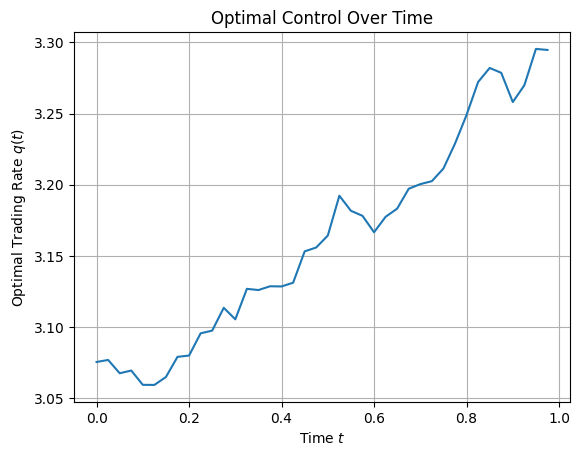

In [ ]:
def simulate_control_path(model, y0=None, seed=42):
    torch.manual_seed(seed)
    model.eval()

    # Initial state
    if y0 is None:
        y = torch.tensor([[0.0, 50.0, 1.0, 45.0]], dtype=torch.float32, device=device)  # (X, P, D, B)
    else:
        y = y0.clone().to(device)

    X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
    t = torch.zeros(1, 1, device=device)

    q_traj = []
    t_traj = []

    for i in range(N):
        t_input = t.clone()
        q = model.q_net(t_input, y).detach().cpu().numpy()[0, 0]

        q_traj.append(q)
        t_traj.append(t.item())

        # Simulate forward SDE
        dW = torch.randn(1, 3, device=device) * np.sqrt(dt)
        dWP = dW[:, 0:1]
        dWD = dW[:, 1:2]
        dWB = dW[:, 2:3]

        dX = q * dt
        dP = (mu_P + gamma * q) * dt + sigma_P * dWP
        dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
        dB = sigma_B * dWB

        X = X + dX
        P = P + dP
        D = D + dD
        B = B + dB
        y = torch.cat([X, P, D, B], dim=1)
        t += dt

    return t_traj, q_traj

t_vals, q_vals = simulate_control_path(model, seed=np.random.randint(0, 100))

plt.plot(t_vals, q_vals)
plt.xlabel("Time $t$")
plt.ylabel("Optimal Trading Rate $q(t)$")
plt.title("Optimal Control Over Time")
plt.grid(True)
plt.show()

#### Terminal State in imbalance price and imbalance position B(T) and I(T)

In [55]:
def sample_terminal_states(model, n_samples=1000):
    model.eval()
    X_list, D_list, B_list, I_list = [], [], [], []

    with torch.no_grad():
        for _ in range(n_samples // batch_size):
            y = torch.zeros(batch_size, dim, device=device)  # (X, P, D, B)
            X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
            t = torch.zeros(batch_size, 1, device=device)

            for _ in range(N):
                q = model.q_net(t, y)
                dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
                dWP = dW[:, 0:1]
                dWT = dW[:, 1:2]
                dWB = dW[:, 2:3]

                dX = q * dt
                dP = (mu_P + gamma * q) * dt + sigma_P * dWP
                dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
                dB = sigma_B * dWB

                X = X + dX
                P = P + dP
                D = D + dD
                B = B + dB
                y = torch.cat([X, P, D, B], dim=1)
                t += dt

            I = X - D + xi
            X_list.append(X.cpu())
            D_list.append(D.cpu())
            B_list.append(B.cpu())
            I_list.append(I.cpu())

    return (
        torch.cat(X_list).squeeze().numpy(),
        torch.cat(D_list).squeeze().numpy(),
        torch.cat(B_list).squeeze().numpy(),
        torch.cat(I_list).squeeze().numpy()
    )


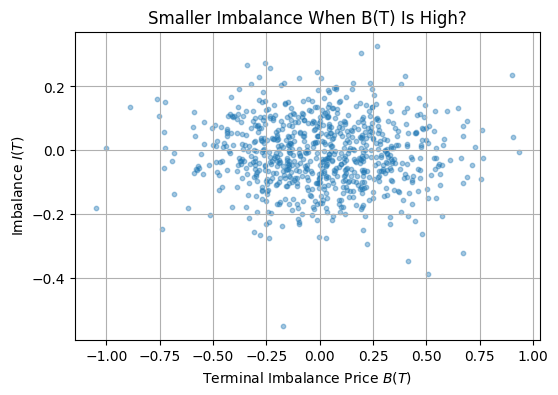

In [66]:
X_T, D_T, B_T, I_T = sample_terminal_states(model)

plt.figure(figsize=(6,4))
plt.scatter(B_T, I_T, alpha=0.4, s=10)
plt.xlabel("Terminal Imbalance Price $B(T)$")
plt.ylabel("Imbalance $I(T)$")
plt.title("Smaller Imbalance When B(T) Is High?")
plt.grid(True)
plt.show()


#### Correlation between X(T) and D(T)

In [ ]:
print("Correlation X(T) ~ D(T):", np.corrcoef(X_T, D_T)[0,1])

#### Optimal control for multiple simulations 

In [73]:
def simulate_multiple_control_trajectories(model, n_paths=1000):
    model.eval()
    n_steps = N
    all_qs = []

    with torch.no_grad():
        for _ in range(n_paths // batch_size):
            y = torch.zeros(batch_size, dim, device=device)  # (X, P, D, B)
            t = torch.zeros(batch_size, 1, device=device)

            batch_qs = []

            for _ in range(n_steps):
                q = model.q_net(t, y).squeeze(-1)  # shape: (batch,)
                batch_qs.append(q.cpu().numpy())

                # simulate next state
                dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
                dWP = dW[:, 0:1]
                dWT = dW[:, 1:2]
                dWB = dW[:, 2:3]

                q_reshaped = q.unsqueeze(-1)

                dX = q_reshaped * dt
                dP = (mu_P + gamma * q_reshaped) * dt + sigma_P * dWP
                dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
                dB = sigma_B * dWB

                X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
                X += dX
                P += dP
                D += dD
                B += dB
                y = torch.cat([X, P, D, B], dim=1)
                t += dt

            all_qs.append(np.stack(batch_qs, axis=0))  # shape: (T, batch)

    all_qs = np.concatenate(all_qs, axis=1)  # shape: (T, total_samples)
    return all_qs  # q values at each time step


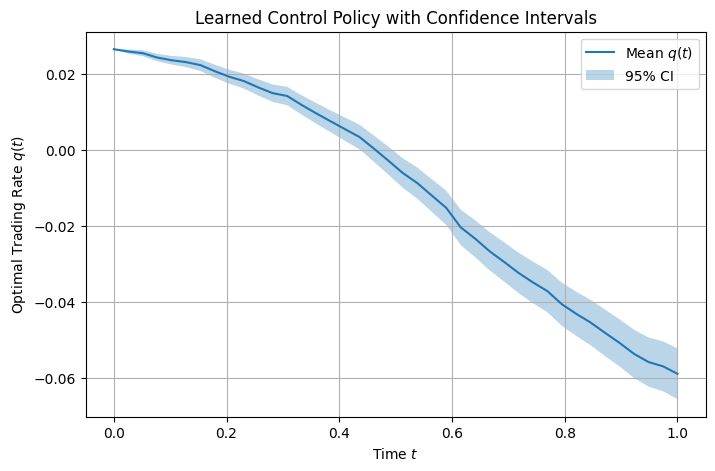

In [74]:
all_qs = simulate_multiple_control_trajectories(model, n_paths=1000)
timesteps = np.linspace(0, T, N)

mean_q = all_qs.mean(axis=1)
std_q = all_qs.std(axis=1)
ci95 = 1.96 * std_q / np.sqrt(all_qs.shape[1])  # 95% CI

plt.figure(figsize=(8,5))
plt.plot(timesteps, mean_q, label="Mean $q(t)$")
plt.fill_between(timesteps, mean_q - ci95, mean_q + ci95, alpha=0.3, label="95% CI")
plt.xlabel("Time $t$")
plt.ylabel("Optimal Trading Rate $q(t)$")
plt.title("Learned Control Policy with Confidence Intervals")
plt.grid(True)
plt.legend()
plt.show()


#### Optimal cost function for multiple simulations

In [61]:
def simulate_value_trajectories(model, n_paths=1000):
    model.eval()
    all_Y = []

    with torch.no_grad():
        for _ in range(n_paths // batch_size):
            y = torch.zeros(batch_size, dim, device=device)  # (X, P, D, B)
            X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
            t = torch.zeros(batch_size, 1, device=device)

            Y = model.Y0.repeat(batch_size, 1)
            Ys = []

            for _ in range(N):
                t_input = t.clone()
                z = model.z_net(t_input, y)
                q = model.q_net(t_input, y)
                f = generator(y, q)

                dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
                dWP, dWT, dWB = dW[:, 0:1], dW[:, 1:2], dW[:, 2:3]

                dX = q * dt
                dP = (mu_P + gamma * q) * dt + sigma_P * dWP
                dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
                dB = sigma_B * dWB

                X += dX
                P += dP
                D += dD
                B += dB
                y = torch.cat([X, P, D, B], dim=1)

                Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)
                Ys.append(Y.cpu().numpy())
                t += dt

            all_Y.append(np.stack(Ys, axis=0))  # shape: (T, batch)

    all_Y = np.concatenate(all_Y, axis=1)  # shape: (T, total_paths)
    return all_Y


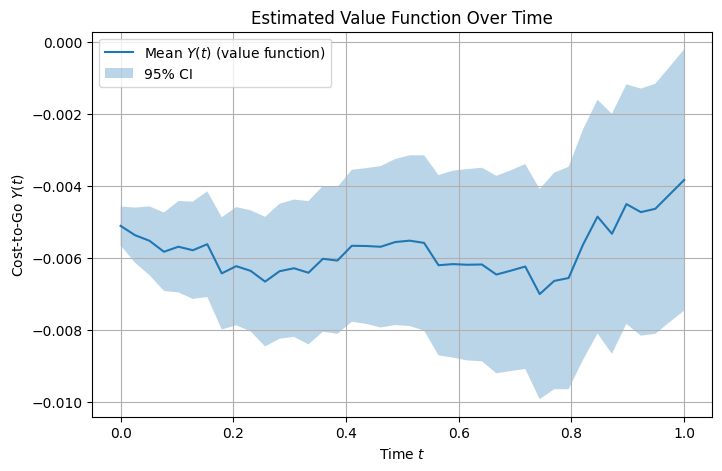

In [63]:
all_Y = simulate_value_trajectories(model, n_paths=1000)
timesteps = np.linspace(0, T, N)

mean_Y = all_Y.mean(axis=1).squeeze()
std_Y = all_Y.std(axis=1).squeeze()
ci95_Y = 1.96 * std_Y / np.sqrt(all_Y.shape[1])

plt.figure(figsize=(8,5))
plt.plot(timesteps, mean_Y, label="Mean $Y(t)$ (value function)")
plt.fill_between(timesteps, mean_Y - ci95_Y, mean_Y + ci95_Y, alpha=0.3, label="95% CI")
plt.xlabel("Time $t$")
plt.ylabel("Cost-to-Go $Y(t)$")
plt.title("Estimated Value Function Over Time")
plt.grid(True)
plt.legend()
plt.show()


#### Overall check

In [85]:
def simulate_all(model, n_paths=1000, y0_single=None, seed=42):
    torch.manual_seed(seed)
    model.eval()
    N_paths = n_paths
    n_batches = N_paths // batch_size
    n_steps = N
    dim_w = 3

    q_trajectories = []
    y_trajectories = []
    Y_trajectories = []
    terminal_stats = {"X": [], "D": [], "B": [], "I": []}

    for _ in range(n_batches):
        y = torch.zeros(batch_size, dim, device=device)
        if y0_single is not None:
            y = y0_single.repeat(batch_size, 1).to(device)
        X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
        t = torch.zeros(batch_size, 1, device=device)

        q_traj = []
        Y = model.Y0.repeat(batch_size, 1)
        Y_traj = []
        y_traj = []

        for _ in range(n_steps):
            t_input = t.clone()
            q = model.q_net(t_input, y).squeeze(-1)
            z = model.z_net(t_input, y)
            f = generator(y, q.unsqueeze(-1))

            dW = torch.randn(batch_size, dim_w, device=device) * np.sqrt(dt)
            dWP, dWT, dWB = dW[:, 0:1], dW[:, 1:2], dW[:, 2:3]

            q_input = q.unsqueeze(-1)
            dX = q_input * dt
            dP = (mu_P + gamma * q_input) * dt + sigma_P * dWP
            dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
            dB = sigma_B * dWB

            X = X + dX
            P = P + dP
            D = D + dD
            B = B + dB
            y = torch.cat([X, P, D, B], dim=1)

            Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)

            t += dt
            q_traj.append(q.detach().cpu().numpy())
            Y_traj.append(Y.detach().cpu().numpy())
            y_traj.append(y.detach().cpu().numpy())

        q_trajectories.append(np.stack(q_traj, axis=0))
        Y_trajectories.append(np.stack(Y_traj, axis=0))
        y_trajectories.append(np.stack(y_traj, axis=0))

        I = X - D + xi
        terminal_stats["X"].append(X.detach().cpu())
        terminal_stats["D"].append(D.detach().cpu())
        terminal_stats["B"].append(B.detach().cpu())
        terminal_stats["I"].append(I.detach().cpu())

    results = {
        "q": np.concatenate(q_trajectories, axis=1),
        "Y": np.concatenate(Y_trajectories, axis=1),
        "final_y": np.concatenate(y_trajectories, axis=1),
        "X_T": torch.cat(terminal_stats["X"]).squeeze().numpy(),
        "D_T": torch.cat(terminal_stats["D"]).squeeze().numpy(),
        "B_T": torch.cat(terminal_stats["B"]).squeeze().numpy(),
        "I_T": torch.cat(terminal_stats["I"]).squeeze().numpy()
    }

    return results

results = simulate_all(model, n_paths=1000, seed=123)

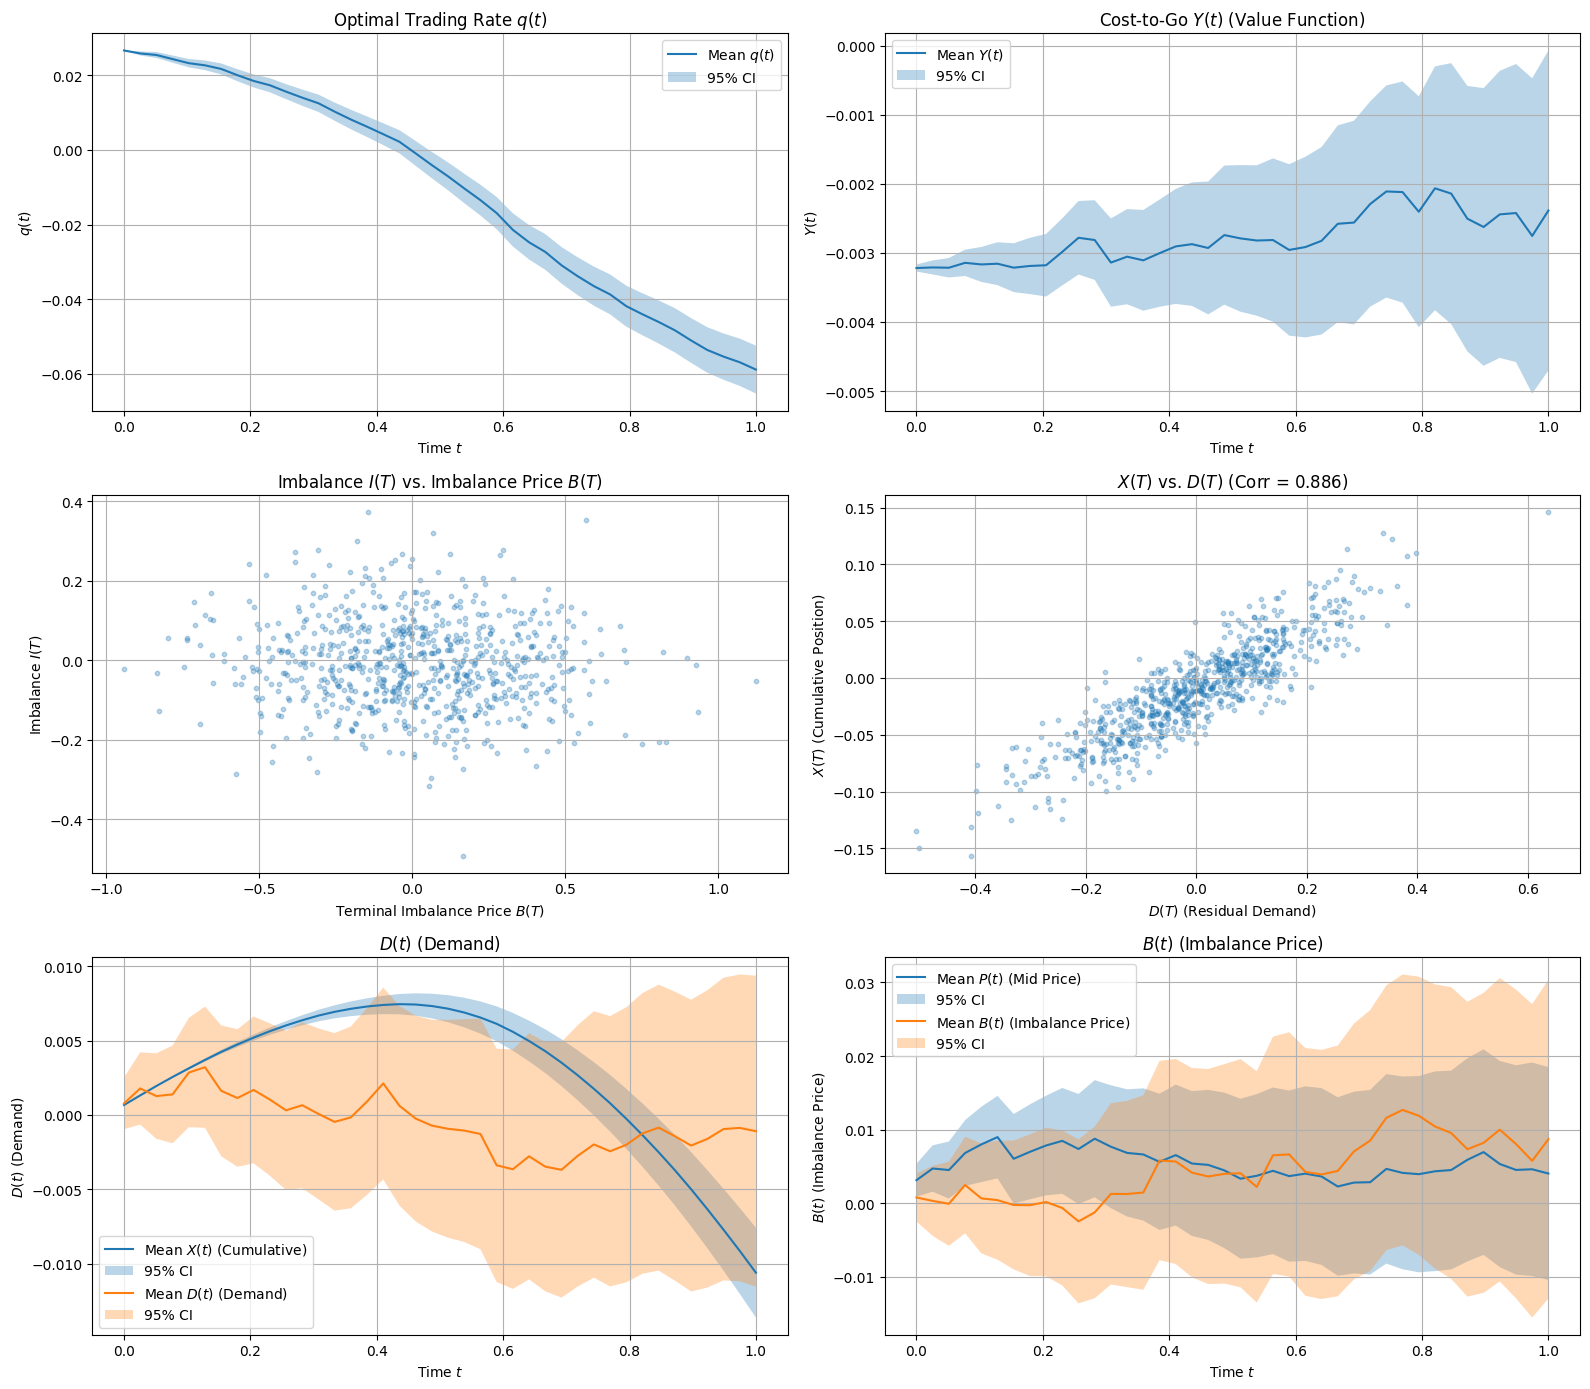

In [86]:
def plot_all_diagnostics(results, timesteps):

    q_vals = results["q"]  # shape: (T, N)
    Y_vals = results["Y"]
    X_T, D_T, B_T, I_T = results["X_T"], results["D_T"], results["B_T"], results["I_T"]

    # Retrieve the state trajectories (assumed shape: (N*T, 4))
    y_all = results["final_y"]  # shape: (T * n_paths, 4)
    n_paths = q_vals.shape[1]
    T = q_vals.shape[0]
    state_trajectories = y_all.reshape(T, -1, 4)

    mean_states = state_trajectories.mean(axis=1)
    std_states = state_trajectories.std(axis=1)
    ci_states = 1.96 * std_states / np.sqrt(n_paths)

    fig, axs = plt.subplots(3, 2, figsize=(16, 14))

    # Subplot 1: Control over time
    mean_q = q_vals.mean(axis=1)
    std_q = q_vals.std(axis=1)
    ci_q = 1.96 * std_q / np.sqrt(n_paths)
    axs[0, 0].plot(timesteps, mean_q, label="Mean $q(t)$")
    axs[0, 0].fill_between(timesteps, mean_q - ci_q, mean_q + ci_q, alpha=0.3, label="95% CI")
    axs[0, 0].set_title("Optimal Trading Rate $q(t)$")
    axs[0, 0].set_xlabel("Time $t$")
    axs[0, 0].set_ylabel("$q(t)$")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Subplot 2: Value function over time
    mean_Y = Y_vals.mean(axis=1).squeeze()
    std_Y = Y_vals.std(axis=1).squeeze()
    ci_Y = 1.96 * std_Y / np.sqrt(Y_vals.shape[1])
    axs[0, 1].plot(timesteps, mean_Y, label="Mean $Y(t)$")
    axs[0, 1].fill_between(timesteps, mean_Y - ci_Y, mean_Y + ci_Y, alpha=0.3, label="95% CI")
    axs[0, 1].set_title("Cost-to-Go $Y(t)$ (Value Function)")
    axs[0, 1].set_xlabel("Time $t$")
    axs[0, 1].set_ylabel("$Y(t)$")
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Subplot 3: Scatter of imbalance vs B(T)
    axs[1, 0].scatter(B_T, I_T, alpha=0.3, s=10)
    axs[1, 0].set_xlabel("Terminal Imbalance Price $B(T)$")
    axs[1, 0].set_ylabel("Imbalance $I(T)$")
    axs[1, 0].set_title("Imbalance $I(T)$ vs. Imbalance Price $B(T)$")
    axs[1, 0].grid(True)

    # Subplot 4: X(T) vs D(T)
    axs[1, 1].scatter(D_T, X_T, alpha=0.3, s=10)
    corr = np.corrcoef(X_T, D_T)[0, 1]
    axs[1, 1].set_title(f"$X(T)$ vs. $D(T)$ (Corr = {corr:.3f})")
    axs[1, 1].set_xlabel("$D(T)$ (Residual Demand)")
    axs[1, 1].set_ylabel("$X(T)$ (Cumulative Position)")
    axs[1, 1].grid(True)

    # Subplot 5: All states with confidence bands
    labels = ["$X(t)$ (Cumulative)", "$P(t)$ (Mid Price)", "$D(t)$ (Demand)", "$B(t)$ (Imbalance Price)"]
    for i in range(4):
        axs[2, i % 2].plot(timesteps, mean_states[:, i], label=f"Mean {labels[i]}")
        axs[2, i % 2].fill_between(timesteps,
                                   mean_states[:, i] - ci_states[:, i],
                                   mean_states[:, i] + ci_states[:, i],
                                   alpha=0.3, label="95% CI")
        axs[2, i % 2].set_title(labels[i])
        axs[2, i % 2].set_xlabel("Time $t$")
        axs[2, i % 2].set_ylabel(labels[i])
        axs[2, i % 2].grid(True)
        axs[2, i % 2].legend()

    plt.tight_layout()
    plt.show()

timesteps = np.linspace(0, T, N)
plot_all_diagnostics(results, timesteps)